In [ ]:
#Object Detection using Faster RCNN
import os
import xml.etree.ElementTree as E
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import transforms as T

import utils

In [ ]:
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

from typing import List, Optional
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches
from pathlib import Path

def plot_bboxes(
  image_file,
  bboxes: List[List[float]],
  xywh: bool = False,
  labels: Optional[List[str]] = None
) -> None:

    fig = plt.figure()

    # add axes to the image
    ax = fig.add_axes([0, 0, 1, 1])

    # image_folder = Path(image_file).parent

    # # read and plot the image
    # image = plt.imread(image_file)
    plt.imshow(image_file.permute(1,2,0))

    # Iterate over all the bounding boxes
    for i, bbox in enumerate(bboxes):
        if xywh:
          xmin, ymin, w, h = bbox
        else:
          xmin, ymin, xmax, ymax = bbox
          w = xmax - xmin
          h = ymax - ymin

        # add bounding boxes to the image
        box = patches.Rectangle(
            (xmin, ymin), w, h, edgecolor="red", facecolor="none"
        )

        ax.add_patch(box)

        if labels is not None:
          rx, ry = box.get_xy()
          cx = rx + box.get_width()/2.0
          cy = ry + box.get_height()/8.0
          l = ax.annotate(
            labels[i],
            (cx, cy),
            fontsize=8,
            fontweight="bold",
            color="white",
            ha='center',
            va='center'
          )
          l.set_bbox(
            dict(facecolor='red', alpha=0.5, edgecolor='red')
          )

    plt.axis('off')

In [ ]:
PATH_TRAIN = "./Fruits_Data_Set/train_zip/train"
PATH_TEST = "./Fruits_Data_Set/test_zip/test"

In [ ]:
class FruitsDataset(Dataset):
    def __init__(self, path_train=PATH_TRAIN, path_test=PATH_TEST, 
                 is_train=True, transforms=get_transform):
        super(FruitsDataset, self).__init__()
        if is_train:
            path = path_train
        else:
            path = path_test
        files = os.listdir(path)
        self.img_list = [os.path.join(path, file) for file in files if '.jpg' in file]
        self.label_list = [os.path.join(path, file) for file in files if '.xml' in file]
        self.classes = {"apple": 1, "banana":2, "orange":3}
        self.transforms = transforms(is_train)
        self.img_list = sorted(self.img_list)
        self.label_list = sorted(self.label_list)
        
        assert len(self.img_list) == len(self.label_list)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):

        img_path = self.img_list[idx]
        label_path = self.label_list[idx]

        img = Image.open(img_path).convert("RGB")
        
        root = E.parse(label_path).getroot()
        labels=[self.classes[str(name.text)] for name in root.findall("object/name")]
        xmin_list = [float(xmin.text) for xmin in root.findall("object/bndbox/xmin")]
        ymin_list = [float(ymin.text) for ymin in root.findall("object/bndbox/ymin")]
        xmax_list = [float(xmax.text) for xmax in root.findall("object/bndbox/xmax")]
        ymax_list = [float(ymax.text) for ymax in root.findall("object/bndbox/ymax")]
        boxes = [[xmin, ymin, xmax, ymax] for xmin, ymin, xmax, ymax \
                 in zip(xmin_list, ymin_list, xmax_list, ymax_list)]

        image_id = torch.tensor([idx])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((labels.shape[0]), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 4  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [ ]:
dataset = FruitsDataset(is_train=True)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

In [ ]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

# use our dataset and defined transformations
dataset = FruitsDataset(is_train=True)
dataset_test = FruitsDataset(is_train=False) 

# # split the dataset in train and test set
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)



# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)



# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [  0/120]  eta: 0:04:40  lr: 0.000047  loss: 1.8652 (1.8652)  loss_classifier: 1.5660 (1.5660)  loss_box_reg: 0.2966 (0.2966)  loss_objectness: 0.0016 (0.0016)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 2.3368  data: 0.3222  max mem: 2476
Epoch: [0]  [ 10/120]  eta: 0:00:40  lr: 0.000467  loss: 1.3224 (1.3082)  loss_classifier: 1.1289 (1.0305)  loss_box_reg: 0.2356 (0.2646)  loss_objectness: 0.0016 (0.0047)  loss_rpn_box_reg: 0.0063 (0.0084)  time: 0.3711  data: 0.0325  max mem: 2832
Epoch: [0]  [ 20/120]  eta: 0:00:27  lr: 0.000886  loss: 0.9035 (1.0240)  loss_classifier: 0.5277 (0.7196)  loss_box_reg: 0.2356 (0.2923)  loss_objectness: 0.0018 (0.0041)  loss_rpn_box_reg: 0.0062 (0.0080)  time: 0.1741  data: 0.0038  max mem: 2853
Epoch: [0]  [ 30/120]  eta: 0:00:22  lr: 0.001306  loss: 0.6067 (0.8600)  loss_classifier: 0.2530 (0.5641)  loss_box_reg: 0.2902 (0.2849)  loss_objectness: 0.0026 (0.0044)  loss_rpn_box_reg: 0.0053 (0.0066)  time: 0.1759  data: 0.0042  max mem: 3479


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [0]  [ 50/120]  eta: 0:00:15  lr: 0.002146  loss: 0.3508 (0.6847)  loss_classifier: 0.1238 (0.4006)  loss_box_reg: 0.2234 (0.2724)  loss_objectness: 0.0022 (0.0044)  loss_rpn_box_reg: 0.0054 (0.0074)  time: 0.1873  data: 0.0048  max mem: 4146
Epoch: [0]  [ 60/120]  eta: 0:00:13  lr: 0.002565  loss: 0.2218 (0.6352)  loss_classifier: 0.0823 (0.3552)  loss_box_reg: 0.1495 (0.2688)  loss_objectness: 0.0021 (0.0042)  loss_rpn_box_reg: 0.0036 (0.0069)  time: 0.1884  data: 0.0054  max mem: 4146
Epoch: [0]  [ 70/120]  eta: 0:00:10  lr: 0.002985  loss: 0.2983 (0.5957)  loss_classifier: 0.0981 (0.3203)  loss_box_reg: 0.1768 (0.2645)  loss_objectness: 0.0021 (0.0041)  loss_rpn_box_reg: 0.0035 (0.0069)  time: 0.1813  data: 0.0050  max mem: 4146
Epoch: [0]  [ 80/120]  eta: 0:00:08  lr: 0.003405  loss: 0.2428 (0.5527)  loss_classifier: 0.0832 (0.2902)  loss_box_reg: 0.1552 (0.2513)  loss_objectness: 0.0005 (0.0037)  loss_rpn_box_reg: 0.0065 (0.0075)  time: 0.1780  data: 0.0047  max mem: 4146


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [0]  [100/120]  eta: 0:00:04  lr: 0.004244  loss: 0.2789 (0.5161)  loss_classifier: 0.0761 (0.2536)  loss_box_reg: 0.1827 (0.2493)  loss_objectness: 0.0031 (0.0044)  loss_rpn_box_reg: 0.0102 (0.0087)  time: 0.1883  data: 0.0059  max mem: 4146
Epoch: [0]  [110/120]  eta: 0:00:02  lr: 0.004664  loss: 0.2199 (0.4934)  loss_classifier: 0.0722 (0.2388)  loss_box_reg: 0.1299 (0.2412)  loss_objectness: 0.0026 (0.0046)  loss_rpn_box_reg: 0.0090 (0.0088)  time: 0.1872  data: 0.0051  max mem: 4146
Epoch: [0]  [119/120]  eta: 0:00:00  lr: 0.005000  loss: 0.2347 (0.4753)  loss_classifier: 0.0864 (0.2269)  loss_box_reg: 0.1459 (0.2353)  loss_objectness: 0.0022 (0.0045)  loss_rpn_box_reg: 0.0070 (0.0086)  time: 0.1762  data: 0.0042  max mem: 4146
Epoch: [0] Total time: 0:00:24 (0.2002 s / it)
creating index...
index created!
Test:  [ 0/60]  eta: 0:00:19  model_time: 0.0712 (0.0712)  evaluator_time: 0.0028 (0.0028)  time: 0.3309  data: 0.2563  max mem: 4146
Test:  [59/60]  eta: 0:00:00  model_

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [1]  [ 40/120]  eta: 0:00:14  lr: 0.005000  loss: 0.2412 (0.2784)  loss_classifier: 0.0707 (0.0883)  loss_box_reg: 0.1660 (0.1743)  loss_objectness: 0.0064 (0.0057)  loss_rpn_box_reg: 0.0077 (0.0102)  time: 0.1692  data: 0.0047  max mem: 4146
Epoch: [1]  [ 50/120]  eta: 0:00:12  lr: 0.005000  loss: 0.2337 (0.2661)  loss_classifier: 0.0717 (0.0881)  loss_box_reg: 0.1432 (0.1622)  loss_objectness: 0.0036 (0.0055)  loss_rpn_box_reg: 0.0077 (0.0103)  time: 0.1760  data: 0.0046  max mem: 4146
Epoch: [1]  [ 60/120]  eta: 0:00:10  lr: 0.005000  loss: 0.1221 (0.2464)  loss_classifier: 0.0410 (0.0807)  loss_box_reg: 0.0839 (0.1508)  loss_objectness: 0.0017 (0.0052)  loss_rpn_box_reg: 0.0060 (0.0097)  time: 0.1786  data: 0.0045  max mem: 4146
Epoch: [1]  [ 70/120]  eta: 0:00:09  lr: 0.005000  loss: 0.1243 (0.2361)  loss_classifier: 0.0410 (0.0781)  loss_box_reg: 0.0700 (0.1436)  loss_objectness: 0.0014 (0.0049)  loss_rpn_box_reg: 0.0054 (0.0094)  time: 0.1806  data: 0.0049  max mem: 4146


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [2]  [ 20/120]  eta: 0:00:19  lr: 0.005000  loss: 0.1659 (0.1765)  loss_classifier: 0.0464 (0.0506)  loss_box_reg: 0.1091 (0.1169)  loss_objectness: 0.0008 (0.0024)  loss_rpn_box_reg: 0.0048 (0.0067)  time: 0.1813  data: 0.0043  max mem: 4146


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [2]  [ 30/120]  eta: 0:00:17  lr: 0.005000  loss: 0.1479 (0.1736)  loss_classifier: 0.0454 (0.0512)  loss_box_reg: 0.0898 (0.1145)  loss_objectness: 0.0009 (0.0021)  loss_rpn_box_reg: 0.0040 (0.0057)  time: 0.1831  data: 0.0041  max mem: 4146
Epoch: [2]  [ 40/120]  eta: 0:00:15  lr: 0.005000  loss: 0.1479 (0.1810)  loss_classifier: 0.0485 (0.0536)  loss_box_reg: 0.0800 (0.1187)  loss_objectness: 0.0012 (0.0023)  loss_rpn_box_reg: 0.0044 (0.0064)  time: 0.1822  data: 0.0042  max mem: 4146
Epoch: [2]  [ 50/120]  eta: 0:00:13  lr: 0.005000  loss: 0.1649 (0.1796)  loss_classifier: 0.0542 (0.0547)  loss_box_reg: 0.1021 (0.1161)  loss_objectness: 0.0014 (0.0022)  loss_rpn_box_reg: 0.0047 (0.0066)  time: 0.1841  data: 0.0052  max mem: 4146
Epoch: [2]  [ 60/120]  eta: 0:00:11  lr: 0.005000  loss: 0.1365 (0.1785)  loss_classifier: 0.0503 (0.0532)  loss_box_reg: 0.0914 (0.1164)  loss_objectness: 0.0013 (0.0023)  loss_rpn_box_reg: 0.0045 (0.0066)  time: 0.1817  data: 0.0052  max mem: 4146


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [3]  [ 20/120]  eta: 0:00:18  lr: 0.000500  loss: 0.1074 (0.1258)  loss_classifier: 0.0326 (0.0387)  loss_box_reg: 0.0679 (0.0807)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0023 (0.0050)  time: 0.1714  data: 0.0045  max mem: 4162


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [3]  [ 30/120]  eta: 0:00:16  lr: 0.000500  loss: 0.0928 (0.1313)  loss_classifier: 0.0310 (0.0404)  loss_box_reg: 0.0557 (0.0847)  loss_objectness: 0.0004 (0.0016)  loss_rpn_box_reg: 0.0021 (0.0046)  time: 0.1743  data: 0.0051  max mem: 4162
Epoch: [3]  [ 40/120]  eta: 0:00:14  lr: 0.000500  loss: 0.1030 (0.1276)  loss_classifier: 0.0324 (0.0396)  loss_box_reg: 0.0557 (0.0823)  loss_objectness: 0.0004 (0.0014)  loss_rpn_box_reg: 0.0027 (0.0042)  time: 0.1791  data: 0.0047  max mem: 4162
Epoch: [3]  [ 50/120]  eta: 0:00:12  lr: 0.000500  loss: 0.1047 (0.1299)  loss_classifier: 0.0383 (0.0405)  loss_box_reg: 0.0653 (0.0835)  loss_objectness: 0.0003 (0.0017)  loss_rpn_box_reg: 0.0033 (0.0042)  time: 0.1819  data: 0.0041  max mem: 4162
Epoch: [3]  [ 60/120]  eta: 0:00:11  lr: 0.000500  loss: 0.1134 (0.1275)  loss_classifier: 0.0304 (0.0403)  loss_box_reg: 0.0729 (0.0813)  loss_objectness: 0.0010 (0.0016)  loss_rpn_box_reg: 0.0034 (0.0042)  time: 0.1841  data: 0.0042  max mem: 4162


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [3]  [ 70/120]  eta: 0:00:09  lr: 0.000500  loss: 0.0784 (0.1247)  loss_classifier: 0.0284 (0.0393)  loss_box_reg: 0.0467 (0.0792)  loss_objectness: 0.0010 (0.0016)  loss_rpn_box_reg: 0.0020 (0.0046)  time: 0.1842  data: 0.0042  max mem: 4162
Epoch: [3]  [ 80/120]  eta: 0:00:07  lr: 0.000500  loss: 0.1016 (0.1252)  loss_classifier: 0.0235 (0.0390)  loss_box_reg: 0.0631 (0.0794)  loss_objectness: 0.0009 (0.0015)  loss_rpn_box_reg: 0.0040 (0.0052)  time: 0.1861  data: 0.0055  max mem: 4162
Epoch: [3]  [ 90/120]  eta: 0:00:05  lr: 0.000500  loss: 0.1191 (0.1261)  loss_classifier: 0.0335 (0.0396)  loss_box_reg: 0.0720 (0.0798)  loss_objectness: 0.0008 (0.0015)  loss_rpn_box_reg: 0.0044 (0.0052)  time: 0.1863  data: 0.0060  max mem: 4162
Epoch: [3]  [100/120]  eta: 0:00:03  lr: 0.000500  loss: 0.1045 (0.1238)  loss_classifier: 0.0335 (0.0389)  loss_box_reg: 0.0632 (0.0780)  loss_objectness: 0.0007 (0.0015)  loss_rpn_box_reg: 0.0039 (0.0053)  time: 0.1901  data: 0.0052  max mem: 4162


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [4]  [ 10/120]  eta: 0:00:25  lr: 0.000500  loss: 0.1141 (0.1255)  loss_classifier: 0.0366 (0.0360)  loss_box_reg: 0.0757 (0.0857)  loss_objectness: 0.0002 (0.0004)  loss_rpn_box_reg: 0.0028 (0.0033)  time: 0.2338  data: 0.0377  max mem: 4162


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [4]  [ 20/120]  eta: 0:00:21  lr: 0.000500  loss: 0.0996 (0.1118)  loss_classifier: 0.0332 (0.0352)  loss_box_reg: 0.0613 (0.0731)  loss_objectness: 0.0002 (0.0003)  loss_rpn_box_reg: 0.0019 (0.0032)  time: 0.1879  data: 0.0039  max mem: 4162
Epoch: [4]  [ 30/120]  eta: 0:00:18  lr: 0.000500  loss: 0.0923 (0.1102)  loss_classifier: 0.0319 (0.0353)  loss_box_reg: 0.0513 (0.0709)  loss_objectness: 0.0003 (0.0006)  loss_rpn_box_reg: 0.0025 (0.0035)  time: 0.1843  data: 0.0046  max mem: 4162
Epoch: [4]  [ 40/120]  eta: 0:00:15  lr: 0.000500  loss: 0.0777 (0.1111)  loss_classifier: 0.0248 (0.0344)  loss_box_reg: 0.0436 (0.0717)  loss_objectness: 0.0005 (0.0007)  loss_rpn_box_reg: 0.0034 (0.0044)  time: 0.1789  data: 0.0046  max mem: 4162
Epoch: [4]  [ 50/120]  eta: 0:00:13  lr: 0.000500  loss: 0.0763 (0.1077)  loss_classifier: 0.0224 (0.0330)  loss_box_reg: 0.0436 (0.0693)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0051 (0.0046)  time: 0.1808  data: 0.0044  max mem: 4162


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [5]  [ 30/120]  eta: 0:00:18  lr: 0.000500  loss: 0.0823 (0.0954)  loss_classifier: 0.0275 (0.0306)  loss_box_reg: 0.0518 (0.0598)  loss_objectness: 0.0004 (0.0010)  loss_rpn_box_reg: 0.0023 (0.0040)  time: 0.1853  data: 0.0045  max mem: 4162
Epoch: [5]  [ 40/120]  eta: 0:00:15  lr: 0.000500  loss: 0.0697 (0.0891)  loss_classifier: 0.0239 (0.0292)  loss_box_reg: 0.0398 (0.0548)  loss_objectness: 0.0004 (0.0010)  loss_rpn_box_reg: 0.0023 (0.0041)  time: 0.1791  data: 0.0045  max mem: 4162
Epoch: [5]  [ 50/120]  eta: 0:00:13  lr: 0.000500  loss: 0.0745 (0.0922)  loss_classifier: 0.0239 (0.0295)  loss_box_reg: 0.0416 (0.0577)  loss_objectness: 0.0005 (0.0010)  loss_rpn_box_reg: 0.0018 (0.0040)  time: 0.1725  data: 0.0040  max mem: 4162
Epoch: [5]  [ 60/120]  eta: 0:00:11  lr: 0.000500  loss: 0.1055 (0.1012)  loss_classifier: 0.0335 (0.0320)  loss_box_reg: 0.0686 (0.0636)  loss_objectness: 0.0009 (0.0012)  loss_rpn_box_reg: 0.0027 (0.0043)  time: 0.1796  data: 0.0043  max mem: 4162


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [5]  [ 80/120]  eta: 0:00:07  lr: 0.000500  loss: 0.0729 (0.1016)  loss_classifier: 0.0233 (0.0317)  loss_box_reg: 0.0463 (0.0641)  loss_objectness: 0.0009 (0.0013)  loss_rpn_box_reg: 0.0028 (0.0045)  time: 0.1911  data: 0.0056  max mem: 4162
Epoch: [5]  [ 90/120]  eta: 0:00:05  lr: 0.000500  loss: 0.0773 (0.1036)  loss_classifier: 0.0225 (0.0323)  loss_box_reg: 0.0522 (0.0656)  loss_objectness: 0.0007 (0.0012)  loss_rpn_box_reg: 0.0032 (0.0044)  time: 0.1791  data: 0.0063  max mem: 4162


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [5]  [100/120]  eta: 0:00:03  lr: 0.000500  loss: 0.0806 (0.1033)  loss_classifier: 0.0225 (0.0319)  loss_box_reg: 0.0522 (0.0658)  loss_objectness: 0.0007 (0.0012)  loss_rpn_box_reg: 0.0026 (0.0044)  time: 0.1709  data: 0.0054  max mem: 4162
Epoch: [5]  [110/120]  eta: 0:00:01  lr: 0.000500  loss: 0.0822 (0.1049)  loss_classifier: 0.0206 (0.0325)  loss_box_reg: 0.0499 (0.0669)  loss_objectness: 0.0009 (0.0012)  loss_rpn_box_reg: 0.0027 (0.0044)  time: 0.1784  data: 0.0050  max mem: 4162
Epoch: [5]  [119/120]  eta: 0:00:00  lr: 0.000500  loss: 0.1016 (0.1074)  loss_classifier: 0.0291 (0.0331)  loss_box_reg: 0.0732 (0.0687)  loss_objectness: 0.0004 (0.0012)  loss_rpn_box_reg: 0.0041 (0.0044)  time: 0.1806  data: 0.0048  max mem: 4162
Epoch: [5] Total time: 0:00:22 (0.1856 s / it)
creating index...
index created!
Test:  [ 0/60]  eta: 0:00:16  model_time: 0.0384 (0.0384)  evaluator_time: 0.0027 (0.0027)  time: 0.2830  data: 0.2412  max mem: 4162
Test:  [59/60]  eta: 0:00:00  model_

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [6]  [  0/120]  eta: 0:01:04  lr: 0.000050  loss: 0.0855 (0.0855)  loss_classifier: 0.0236 (0.0236)  loss_box_reg: 0.0519 (0.0519)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0096 (0.0096)  time: 0.5406  data: 0.3388  max mem: 4162
Epoch: [6]  [ 10/120]  eta: 0:00:22  lr: 0.000050  loss: 0.0762 (0.0930)  loss_classifier: 0.0212 (0.0284)  loss_box_reg: 0.0519 (0.0605)  loss_objectness: 0.0003 (0.0006)  loss_rpn_box_reg: 0.0026 (0.0035)  time: 0.2055  data: 0.0335  max mem: 4162


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [6]  [ 20/120]  eta: 0:00:19  lr: 0.000050  loss: 0.0762 (0.1024)  loss_classifier: 0.0212 (0.0304)  loss_box_reg: 0.0491 (0.0681)  loss_objectness: 0.0004 (0.0009)  loss_rpn_box_reg: 0.0020 (0.0030)  time: 0.1762  data: 0.0036  max mem: 4162
Epoch: [6]  [ 30/120]  eta: 0:00:17  lr: 0.000050  loss: 0.0798 (0.1026)  loss_classifier: 0.0212 (0.0305)  loss_box_reg: 0.0444 (0.0673)  loss_objectness: 0.0005 (0.0008)  loss_rpn_box_reg: 0.0029 (0.0040)  time: 0.1867  data: 0.0042  max mem: 4162
Epoch: [6]  [ 40/120]  eta: 0:00:15  lr: 0.000050  loss: 0.0831 (0.1058)  loss_classifier: 0.0219 (0.0320)  loss_box_reg: 0.0444 (0.0689)  loss_objectness: 0.0005 (0.0009)  loss_rpn_box_reg: 0.0024 (0.0039)  time: 0.1878  data: 0.0047  max mem: 4162
Epoch: [6]  [ 50/120]  eta: 0:00:13  lr: 0.000050  loss: 0.0840 (0.1018)  loss_classifier: 0.0251 (0.0318)  loss_box_reg: 0.0519 (0.0648)  loss_objectness: 0.0007 (0.0010)  loss_rpn_box_reg: 0.0022 (0.0042)  time: 0.1768  data: 0.0053  max mem: 4162


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [7]  [ 20/120]  eta: 0:00:19  lr: 0.000050  loss: 0.0919 (0.1079)  loss_classifier: 0.0268 (0.0340)  loss_box_reg: 0.0548 (0.0687)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0028 (0.0039)  time: 0.1836  data: 0.0048  max mem: 4162
Epoch: [7]  [ 30/120]  eta: 0:00:17  lr: 0.000050  loss: 0.1017 (0.1193)  loss_classifier: 0.0282 (0.0376)  loss_box_reg: 0.0620 (0.0759)  loss_objectness: 0.0006 (0.0016)  loss_rpn_box_reg: 0.0024 (0.0042)  time: 0.1853  data: 0.0045  max mem: 4162
Epoch: [7]  [ 40/120]  eta: 0:00:15  lr: 0.000050  loss: 0.1121 (0.1233)  loss_classifier: 0.0336 (0.0377)  loss_box_reg: 0.0763 (0.0798)  loss_objectness: 0.0012 (0.0017)  loss_rpn_box_reg: 0.0028 (0.0041)  time: 0.1821  data: 0.0050  max mem: 4162
Epoch: [7]  [ 50/120]  eta: 0:00:13  lr: 0.000050  loss: 0.1121 (0.1216)  loss_classifier: 0.0336 (0.0381)  loss_box_reg: 0.0712 (0.0773)  loss_objectness: 0.0006 (0.0016)  loss_rpn_box_reg: 0.0028 (0.0045)  time: 0.1810  data: 0.0051  max mem: 4162


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [7]  [ 60/120]  eta: 0:00:11  lr: 0.000050  loss: 0.0644 (0.1124)  loss_classifier: 0.0189 (0.0353)  loss_box_reg: 0.0349 (0.0713)  loss_objectness: 0.0004 (0.0015)  loss_rpn_box_reg: 0.0024 (0.0043)  time: 0.1820  data: 0.0040  max mem: 4162
Epoch: [7]  [ 70/120]  eta: 0:00:09  lr: 0.000050  loss: 0.0595 (0.1062)  loss_classifier: 0.0187 (0.0334)  loss_box_reg: 0.0325 (0.0668)  loss_objectness: 0.0003 (0.0014)  loss_rpn_box_reg: 0.0024 (0.0046)  time: 0.1863  data: 0.0047  max mem: 4162
Epoch: [7]  [ 80/120]  eta: 0:00:07  lr: 0.000050  loss: 0.0684 (0.1091)  loss_classifier: 0.0198 (0.0346)  loss_box_reg: 0.0446 (0.0685)  loss_objectness: 0.0004 (0.0015)  loss_rpn_box_reg: 0.0020 (0.0044)  time: 0.1772  data: 0.0049  max mem: 4162
Epoch: [7]  [ 90/120]  eta: 0:00:05  lr: 0.000050  loss: 0.0911 (0.1064)  loss_classifier: 0.0293 (0.0335)  loss_box_reg: 0.0547 (0.0670)  loss_objectness: 0.0004 (0.0014)  loss_rpn_box_reg: 0.0025 (0.0045)  time: 0.1742  data: 0.0045  max mem: 4162


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [8]  [ 40/120]  eta: 0:00:15  lr: 0.000050  loss: 0.0739 (0.1044)  loss_classifier: 0.0210 (0.0328)  loss_box_reg: 0.0440 (0.0654)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0022 (0.0052)  time: 0.1796  data: 0.0055  max mem: 4162
Epoch: [8]  [ 50/120]  eta: 0:00:13  lr: 0.000050  loss: 0.0832 (0.1065)  loss_classifier: 0.0230 (0.0327)  loss_box_reg: 0.0490 (0.0679)  loss_objectness: 0.0006 (0.0009)  loss_rpn_box_reg: 0.0031 (0.0050)  time: 0.1904  data: 0.0051  max mem: 4162
Epoch: [8]  [ 60/120]  eta: 0:00:11  lr: 0.000050  loss: 0.0625 (0.1012)  loss_classifier: 0.0230 (0.0311)  loss_box_reg: 0.0392 (0.0648)  loss_objectness: 0.0004 (0.0009)  loss_rpn_box_reg: 0.0020 (0.0045)  time: 0.1887  data: 0.0045  max mem: 4162


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [8]  [ 70/120]  eta: 0:00:09  lr: 0.000050  loss: 0.0681 (0.1076)  loss_classifier: 0.0279 (0.0325)  loss_box_reg: 0.0455 (0.0695)  loss_objectness: 0.0004 (0.0009)  loss_rpn_box_reg: 0.0021 (0.0046)  time: 0.1823  data: 0.0050  max mem: 4162
Epoch: [8]  [ 80/120]  eta: 0:00:07  lr: 0.000050  loss: 0.0792 (0.1050)  loss_classifier: 0.0279 (0.0317)  loss_box_reg: 0.0531 (0.0679)  loss_objectness: 0.0011 (0.0010)  loss_rpn_box_reg: 0.0026 (0.0044)  time: 0.1808  data: 0.0049  max mem: 4162
Epoch: [8]  [ 90/120]  eta: 0:00:05  lr: 0.000050  loss: 0.0782 (0.1055)  loss_classifier: 0.0269 (0.0327)  loss_box_reg: 0.0531 (0.0673)  loss_objectness: 0.0004 (0.0010)  loss_rpn_box_reg: 0.0024 (0.0044)  time: 0.1823  data: 0.0044  max mem: 4162
Epoch: [8]  [100/120]  eta: 0:00:03  lr: 0.000050  loss: 0.0807 (0.1042)  loss_classifier: 0.0242 (0.0322)  loss_box_reg: 0.0554 (0.0667)  loss_objectness: 0.0004 (0.0010)  loss_rpn_box_reg: 0.0021 (0.0043)  time: 0.1825  data: 0.0047  max mem: 4162


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [9]  [  0/120]  eta: 0:01:06  lr: 0.000005  loss: 0.1731 (0.1731)  loss_classifier: 0.0343 (0.0343)  loss_box_reg: 0.1261 (0.1261)  loss_objectness: 0.0066 (0.0066)  loss_rpn_box_reg: 0.0061 (0.0061)  time: 0.5548  data: 0.3446  max mem: 4162
Epoch: [9]  [ 10/120]  eta: 0:00:21  lr: 0.000005  loss: 0.0615 (0.0835)  loss_classifier: 0.0214 (0.0250)  loss_box_reg: 0.0378 (0.0544)  loss_objectness: 0.0009 (0.0013)  loss_rpn_box_reg: 0.0023 (0.0028)  time: 0.1953  data: 0.0340  max mem: 4162
Epoch: [9]  [ 20/120]  eta: 0:00:19  lr: 0.000005  loss: 0.0670 (0.0875)  loss_classifier: 0.0214 (0.0294)  loss_box_reg: 0.0431 (0.0527)  loss_objectness: 0.0007 (0.0013)  loss_rpn_box_reg: 0.0025 (0.0041)  time: 0.1724  data: 0.0043  max mem: 4162
Epoch: [9]  [ 30/120]  eta: 0:00:17  lr: 0.000005  loss: 0.0784 (0.0921)  loss_classifier: 0.0243 (0.0297)  loss_box_reg: 0.0491 (0.0568)  loss_objectness: 0.0005 (0.0016)  loss_rpn_box_reg: 0.0025 (0.0039)  time: 0.1896  data: 0.0053  max mem: 4162


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: [9]  [110/120]  eta: 0:00:01  lr: 0.000005  loss: 0.0568 (0.0992)  loss_classifier: 0.0192 (0.0307)  loss_box_reg: 0.0374 (0.0631)  loss_objectness: 0.0002 (0.0012)  loss_rpn_box_reg: 0.0018 (0.0043)  time: 0.1767  data: 0.0050  max mem: 4162
Epoch: [9]  [119/120]  eta: 0:00:00  lr: 0.000005  loss: 0.0733 (0.1018)  loss_classifier: 0.0292 (0.0314)  loss_box_reg: 0.0420 (0.0648)  loss_objectness: 0.0012 (0.0012)  loss_rpn_box_reg: 0.0039 (0.0044)  time: 0.1857  data: 0.0047  max mem: 4162
Epoch: [9] Total time: 0:00:22 (0.1856 s / it)
creating index...
index created!
Test:  [ 0/60]  eta: 0:00:17  model_time: 0.0396 (0.0396)  evaluator_time: 0.0018 (0.0018)  time: 0.2928  data: 0.2507  max mem: 4162
Test:  [59/60]  eta: 0:00:00  model_time: 0.0357 (0.0366)  evaluator_time: 0.0006 (0.0008)  time: 0.0402  data: 0.0018  max mem: 4162
Test: Total time: 0:00:02 (0.0470 s / it)
Averaged stats: model_time: 0.0357 (0.0366)  evaluator_time: 0.0006 (0.0008)
Accumulating evaluation results..

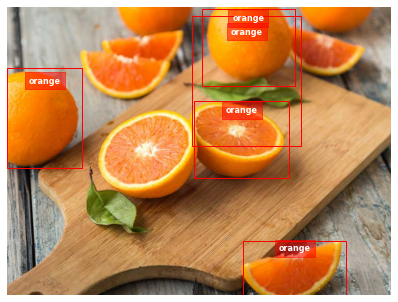

In [ ]:
N = 42 # Change it between 0 to 59 to have results of test set 

data = list(iter(data_loader_test))
classes = {1:'apple', 2:'banana', 3:'orange'}
images,targets = data[N]
images = list(image.to(device) for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(images)   
out  = [{k: v.detach().to('cpu') for k, v in t.items()} for t in predictions][0] 
labels = [classes[x.item()] for x in out['labels']]
plot_bboxes(images[0].to('cpu'), out['boxes'], labels = labels)